In [23]:
import MDAnalysis as mda
import warnings
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from MDAnalysis.analysis import distances
import re
from collections import Counter

warnings.filterwarnings('ignore')

def remove_adjacent(nums):
  i = 0
  while i < len(nums):    
    if nums[i] == nums[i-1]:
        if nums[i] == 0:
            nums.pop(i)
            i -= 1  
    i += 1
  return nums

def occ_dist_1_all(pdb,sel):
    all=pd.DataFrame()
    reps=['rep1', 'rep2', 'rep3']
    vsd=pd.DataFrame()
    for r in reps:
        u=mda.Universe(pdb+'/traj/labelled.gro', pdb+'/traj/'+r+'.xtc')
        vpbs=u.select_atoms('name BB SC1 SC2 and resid '+ sel)
        pip=u.select_atoms('resname POP1 POP2 POP3').residues 
        all=pd.DataFrame()
        for residue in pip:
            count=[]
            for ts in u.trajectory[::250]:
                df=pd.DataFrame(distances.distance_array(residue.atoms.positions,vpbs.positions))
                vc=(df.min()<7).value_counts().get(True)
                if vc is not None and vc>1:
                    count.append(1)
                else: 
                    count.append(0)
            all[residue.resid]=count
            all=all.loc[:, (all.sum() > 1)]

        bindingpips=" ".join(list((all.rolling(2).mean()>0.5).any().index.astype(str)))
        pip=u.select_atoms('resname POP1 POP2 POP3 and resid '+bindingpips).residues
        for residue in pip:
            count=[]
            for ts in u.trajectory[::100]:
                df=pd.DataFrame(distances.distance_array(residue.atoms.positions,vpbs.positions))
                vc=(df.min()<7).value_counts().get(True)
                if vc is not None and vc>0:
                    count.append(vc)
                else: 
                    count.append(0)
            vsd[r+'-'+residue.resname+'-'+str(residue.resid)]=count

    l=[]
    lpip=[]
    for i in vsd.columns:
        clean=remove_adjacent(vsd[i].tolist())
        string="".join(map(str,clean))
        sstring=re.split('0', string)
        a=[]
        for s in sstring:
            if len(s)>199:
                lpip.append(i)
            if len(s)>9:
                l.append(len(s)/10)
    return(l, lpip)
        

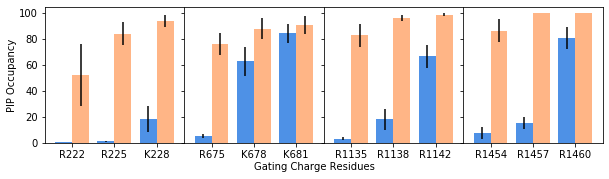

In [29]:
ind=['R222', 'R225', 'K228', 'R675', 'K678', 'K681', 'R1135', 'R1138', 'R1142', 'R1454', 'R1457', 'R1460']
inact=pd.read_csv('/mnt/sdb1/YC/NaV-PIP/Nav1.4/enriched-pip/analysis/contacts/nav1.4_gc.csv', index_col=0)
inact_err=pd.read_csv('/mnt/sdb1/YC/NaV-PIP/Nav1.4/enriched-pip/analysis/contacts/nav1.4_gc_err.csv', index_col=0)
resting = pd.DataFrame(index=ind)

for j in [1,2,3]:
    u=mda.Universe("contact/resting-"+str(j)+".pdb")
    resting["rep "+str(j)]=list(u.atoms.tempfactors)

df=pd.DataFrame(index=ind)
df['inact']=inact.iloc[:, 0]
df['resting']=resting.mean(axis=1)

err=pd.DataFrame(index=ind)
err['inact']=inact_err.iloc[:, 0]
err['resting']=resting.sem(axis=1)

fig, axes = plt.subplots(ncols=4, nrows=1, sharey='all', figsize=(10, 2.5), gridspec_kw={'width_ratios':[1, 1,1, 1], 'wspace': 0.0, 'hspace':0})
df.loc[['R222', 'R225', 'K228']].plot.bar(yerr=err, rot=0, legend=False, color=['#4E91E6', '#FFB586'], ax=axes[0], width=0.8)
df.loc[['R675', 'K678', 'K681']].plot.bar(yerr=err, rot=0, legend=False, color=['#4E91E6', '#FFB586'], ax=axes[1], width=0.8)
df.loc[['R1135', 'R1138', 'R1142']].plot.bar(yerr=err, rot=0, legend=False, color=['#4E91E6', '#FFB586'], ax=axes[2], width=0.8)
df.loc[['R1454', 'R1457', 'R1460']].plot.bar(yerr=err, rot=0, legend=False, color=['#4E91E6', '#FFB586'], ax=axes[3], width=0.8)
fig.text(0.5,-0.01, "Gating Charge Residues", ha="center", va="center")
fig.text(0.08, 0.5, 'PIP Occupancy', ha='center', va='center', rotation='vertical')


plt.savefig('Nav1.4_resting.png', bbox_inches='tight')